# Feature selection

The criteria for selecting predictors for our model is as it follows:

1. Predictors with no zero variance and with 80% or more null values will be dropped out.
2. Consider the following conditions that can be met by a predictor:
    1. It does not have a clear monotonous sense respect to the target. To this task, we will use the Gini coefficient and the bootstrap method.
    2. Its null indicator variable is not meaningful (it's 1 if the predictor is not null and 0 otherwise).
4. If A and B is met, the variable will be droped out. If only A is met, we will drop the predictor and only consider its null indicator variable.
5. From this point, predictor will be discretized using Optimal Binning.
6. Predictors such that their joint probability distribution with the target is not stable in time will not be considered. For this task we use a Chi-square test for homogeneity.
7. Finally, if there is a pair of predictors that have a Pearson's correlation superior to 60%, only predictor with the highest Gini will be selected.

## Dependencies

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import display
from custom_code.feature_selection import null_info_study, gini_coefficient_bootstrapping, OptbinTransformer, test_stability

## Constants

In [13]:
SEED = 42
TEST_SIZE = 0.2
TARGET_COLUMN = "f_3pva18m"
RECORD_DATE_COLUMN = "mes_solicitud"

## Reading Data

In [14]:
df_train = pd.read_csv("./data/df_train_undersampled.csv")
X_train = df_train.drop([TARGET_COLUMN, RECORD_DATE_COLUMN], axis=1)
y_train = df_train[TARGET_COLUMN].values

### Null indicator study

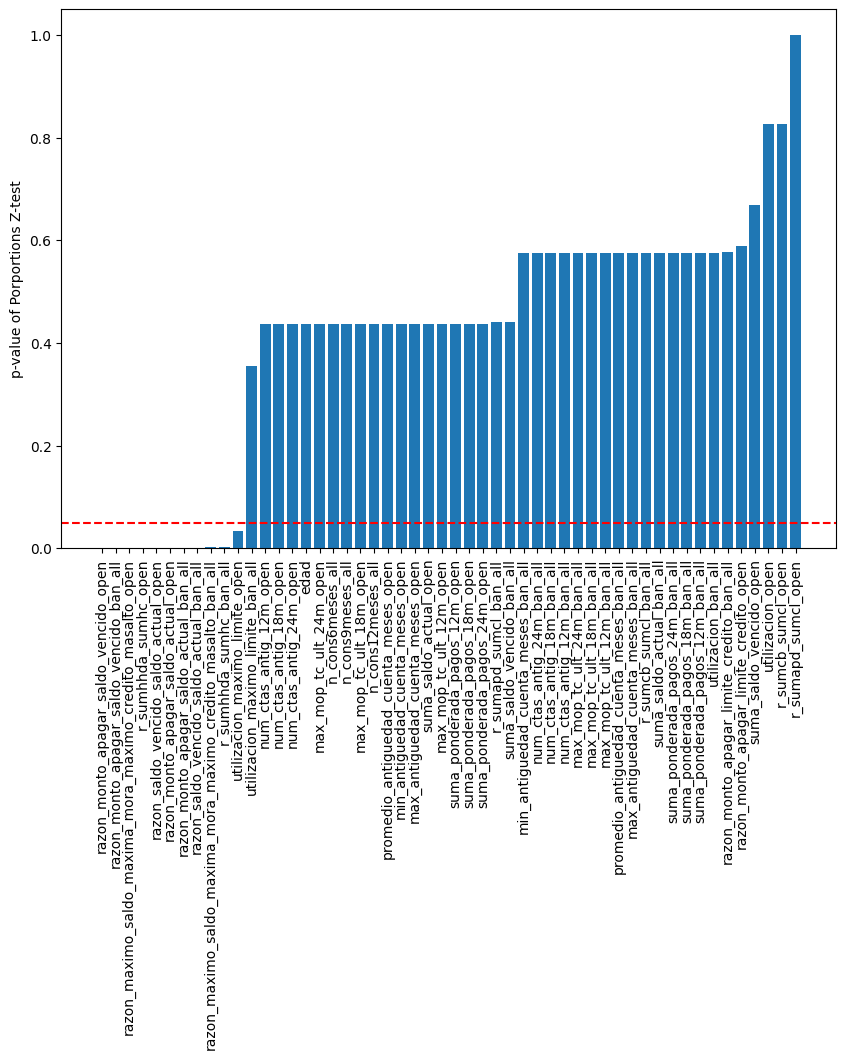

In [15]:
df_null_info_study = null_info_study(X_train, y_train)

### Variance and null values

In [16]:
data = X_train.var()
df_variance = pd.DataFrame({
    "predictor" : data.index, 
    "variance" : data.values, 
    "is_variance_zero" : data.values==0})

data = X_train.isna().mean()
df_null = pd.DataFrame({
    "predictor" : data.index, 
    "null_proportion" : data.values, 
    "is_null_proportion_high" : data.values > 0.80})

### Monotonous Sense

In [17]:
df_ginis = pd.read_csv("./data/df_ginis.csv")
df_ginis["has_monotonous_sense"] = np.maximum(df_ginis["gini_lower_bound"], -0.10) >= np.minimum(df_ginis["gini_upper_bound"], 0.10)
df_ginis["monotonous_sense"] = np.where(df_ginis["gini_lower_bound"] < 0, "descending", "ascending")

## Filtering predictors

In [18]:
df_summary = df_null_info_study.merge(df_variance, on="predictor").merge(df_null, on="predictor").merge(df_ginis, on="predictor")

df_summary["action"] = "keep"

mask = ~(df_summary["has_monotonous_sense"] | df_summary["is_null_info_meaningful"]) 
df_summary.loc[mask, "action"] = "drop"

mask = df_summary["is_variance_zero"] | df_summary["is_null_proportion_high"]
df_summary.loc[mask, "action"] = "drop"

mask = (~df_summary["has_monotonous_sense"]) & df_summary["is_null_info_meaningful"] 
df_summary.loc[mask, "action"] = "take_null_indicator"

mask = df_summary["action"] != "drop"
df_cols_to_keep = df_summary[mask][["predictor", "action", "monotonous_sense"]].copy().reset_index(drop=True)

print("="*120)
print("Number of kept predictors:", len(df_cols_to_keep))
print("="*120)
display(df_cols_to_keep.head())

Number of kept predictors: 33


,predictor,action,monotonous_sense
0,razon_monto_apagar_saldo_actual_open,take_null_indicator,ascending
1,razon_monto_apagar_limite_credito_open,keep,ascending
2,razon_monto_apagar_saldo_vencido_open,take_null_indicator,descending
3,razon_maximo_saldo_maxima_mora_maximo_credito_...,keep,ascending
4,razon_saldo_vencido_saldo_actual_open,take_null_indicator,ascending


## Stability test

Only predictors not dropped out will be tested.

In [19]:
mask = df_summary["action"]=="drop"
predictors_to_drop = df_summary[mask]["predictor"].tolist()

mask = df_summary["action"]=="take_null_indicator"
only_null_indicator = df_summary[mask]["predictor"].tolist()

mask = df_summary["action"]=="keep"
predictors_to_be_mapped = df_summary[mask]["predictor"].tolist()
monotonous_sense = df_summary[mask]["monotonous_sense"].tolist()
predictors_to_be_mapped_and_sense = list(zip(predictors_to_be_mapped, monotonous_sense))

predictors_and_sense = predictors_to_be_mapped_and_sense + [(column, None) for column in only_null_indicator]

df_stability_results = test_stability(df_train, TARGET_COLUMN, RECORD_DATE_COLUMN, predictors_and_sense)

In [21]:
df_summary = df_summary.merge(df_stability_results, on="predictor", how="left")
df_summary.loc[df_summary["is_unstable_variable"]==True, "action"] = "drop"

In [22]:
df_summary.to_csv("./data/df_summary_feature_selection.csv", index=False)

## Transforming design matrix

In [23]:
mask = df_summary["action"]=="drop"
predictors_to_drop = df_summary[mask]["predictor"].tolist()

mask = df_summary["action"]=="take_null_indicator"
only_null_indicator = df_summary[mask]["predictor"].tolist()

mask = df_summary["action"]=="keep"
predictors_to_be_mapped = df_summary[mask]["predictor"].tolist()
monotonous_sense = df_summary[mask]["monotonous_sense"].tolist()
predictors_to_be_mapped_and_sense = list(zip(predictors_to_be_mapped, monotonous_sense))

In [28]:
transformer = OptbinTransformer(predictors_to_drop, only_null_indicator, predictors_to_be_mapped_and_sense)
transformer.fit(X_train, y_train)
X_train_transformed = transformer.transform(X_train)

# saving matrix and transformer

df_train_transformed = X_train_transformed.copy()
df_train_transformed[TARGET_COLUMN] = y_train
df_train_transformed[RECORD_DATE_COLUMN] = df_train[RECORD_DATE_COLUMN]
df_train_transformed.to_csv("./data/df_train_transformed.csv", index=False)

with open("./objects/optbin_transformer.pkl", "wb") as file:
    pickle.dump(transformer, file)